# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import datediff, count, col, when, udf, first, last, max, sum, countDistinct, to_timestamp, from_unixtime, when
from pyspark.sql.types import IntegerType, DoubleType, LongType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, StandardScaler, Normalizer, VectorAssembler, MinMaxScaler, OneHotEncoderEstimator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder






In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load data into a spark dataframe
df = spark.read.json('mini_sparkify_event_data.json')
df.persist

<bound method DataFrame.persist of DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]>

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
print('Number of records: {}'.format(df.count()))

Number of records: 286500


In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Identify columns whith null values

null_cols = [count(when(col(i).isNull(), i)).alias(i) for i in df.columns]
df.select(null_cols).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
# artist, length and song have the same number of null values
# which actions are being performed when artist column is null

df.where("artist is null").groupBy('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|    Submit Downgrade|   63|
|         Thumbs Down| 2546|
|                Home|14457|
|           Downgrade| 2055|
|         Roll Advert| 3933|
|              Logout| 3226|
|       Save Settings|  310|
|Cancellation Conf...|   52|
|               About|  924|
| Submit Registration|    5|
|            Settings| 1514|
|               Login| 3241|
|            Register|   18|
|     Add to Playlist| 6526|
|          Add Friend| 4277|
|           Thumbs Up|12551|
|                Help| 1726|
|             Upgrade|  499|
|               Error|  258|
+--------------------+-----+
only showing top 20 rows



In [9]:
# which actions are being performed when artist column is not null

df.where("artist is not null").groupBy('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



In [10]:
# Identify columns with empty values

empty_cols = [count(when(col(i)=='', i)).alias(i) for i in df.columns]
df.select(empty_cols).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [11]:
# Check the auth status for records where userId is empty

df.where("userId == ''").groupBy('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [12]:
# Auth status for users where the userID is not blank shows that these users are logged in 
# Blank user id indicates that the user is a guest or has logged out

df.where("userId != ''").groupBy('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [13]:
# Drop records where userID is blank

df = df.where("userId != ''")
print('Number of records : {}'.format(df.count()))

Number of records : 278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
# Define churn from cancellation confirmation stage

churn_fn = udf(lambda x: 1 if x == 'Cancellation Confirmation'  else 0, IntegerType())
df = df.withColumn('churn', churn_fn('page'))

In [15]:
df.where('churn == 1').take(5)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', churn=1),
 Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32', churn=1),
 Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', it

In [16]:
# Convert timestamps to date format

df = df.withColumn('reg_date', to_timestamp(from_unixtime(col("registration")/1000,"yyyy-MM-dd hh:mm:ss")))
df = df.withColumn('log_date', to_timestamp(from_unixtime(col("ts")/1000, "yyyy-MM-dd hh:mm:ss")))

In [17]:
df.select("reg_date", "log_date").show(10)

+-------------------+-------------------+
|           reg_date|           log_date|
+-------------------+-------------------+
|2018-09-28 10:22:42|2018-10-01 12:01:57|
|2018-09-30 06:20:30|2018-10-01 12:03:00|
|2018-09-28 10:22:42|2018-10-01 12:06:34|
|2018-09-30 06:20:30|2018-10-01 12:06:56|
|2018-09-28 10:22:42|2018-10-01 12:11:16|
|2018-09-30 06:20:30|2018-10-01 12:11:18|
|2018-09-30 06:20:30|2018-10-01 12:14:46|
|2018-09-28 10:22:42|2018-10-01 12:14:59|
|2018-09-28 10:22:42|2018-10-01 12:15:05|
|2018-09-28 10:22:42|2018-10-01 12:18:04|
+-------------------+-------------------+
only showing top 10 rows



In [18]:
# Pick the max log date

max_log_date = df.select("log_date").rdd.max()[0]

In [19]:
# Create a column last_date which is the date of the latest log for each userId

win = Window.partitionBy("userId").orderBy("log_date")

df = df.withColumn('last_date', when(last('churn').over(win)==1, last('log_date').over(win))
                  .otherwise(max_log_date))

In [20]:
df.where('churn == 1').select('reg_date','log_date','last_date','churn').take(5)

[Row(reg_date=datetime.datetime(2018, 8, 1, 8, 58, 59), log_date=datetime.datetime(2018, 10, 12, 4, 35, 18), last_date=datetime.datetime(2018, 10, 12, 4, 35, 18), churn=1),
 Row(reg_date=datetime.datetime(2018, 9, 27, 8, 43, 7), log_date=datetime.datetime(2018, 10, 17, 7, 39, 32), last_date=datetime.datetime(2018, 10, 17, 7, 39, 32), churn=1),
 Row(reg_date=datetime.datetime(2018, 7, 25, 1, 37, 42), log_date=datetime.datetime(2018, 11, 12, 7, 40, 8), last_date=datetime.datetime(2018, 11, 12, 7, 40, 8), churn=1),
 Row(reg_date=datetime.datetime(2018, 8, 27, 5, 4, 3), log_date=datetime.datetime(2018, 11, 20, 7, 4, 9), last_date=datetime.datetime(2018, 11, 20, 7, 4, 9), churn=1),
 Row(reg_date=datetime.datetime(2018, 8, 23, 11, 19, 40), log_date=datetime.datetime(2018, 10, 16, 10, 30, 37), last_date=datetime.datetime(2018, 10, 16, 10, 30, 37), churn=1)]

In [21]:
df.where('churn == 0').select('reg_date','log_date','last_date','churn').take(5)

[Row(reg_date=datetime.datetime(2018, 9, 27, 2, 45, 40), log_date=datetime.datetime(2018, 10, 8, 1, 2, 16), last_date=datetime.datetime(2018, 12, 3, 1, 11, 16), churn=0),
 Row(reg_date=datetime.datetime(2018, 9, 27, 2, 45, 40), log_date=datetime.datetime(2018, 10, 8, 1, 5, 32), last_date=datetime.datetime(2018, 12, 3, 1, 11, 16), churn=0),
 Row(reg_date=datetime.datetime(2018, 9, 27, 2, 45, 40), log_date=datetime.datetime(2018, 10, 8, 1, 5, 33), last_date=datetime.datetime(2018, 12, 3, 1, 11, 16), churn=0),
 Row(reg_date=datetime.datetime(2018, 9, 27, 2, 45, 40), log_date=datetime.datetime(2018, 10, 8, 1, 9, 55), last_date=datetime.datetime(2018, 12, 3, 1, 11, 16), churn=0),
 Row(reg_date=datetime.datetime(2018, 9, 27, 2, 45, 40), log_date=datetime.datetime(2018, 10, 8, 1, 15, 11), last_date=datetime.datetime(2018, 12, 3, 1, 11, 16), churn=0)]

In [22]:
df = df.withColumn('reg_days', datediff(col('last_date'),col('reg_date')))

In [23]:
# Group the data by the userID 

user_df = df.groupby('userId').agg(
    first('gender').alias('gender'),
    first('reg_date').alias('reg_date'),
    first('log_date').alias('first_date'),
    first('last_date').alias('last_date'),
    first('reg_days').alias('reg_days'),
    last('level').alias('last_level'),
    max('churn').alias('churn'),
    sum('length').alias('total_length'),
    count('song').alias('total_songs'),
    countDistinct('sessionId').alias('num_sessions'),
    countDistinct('artist').alias('num_artists'),
    
    )

In [24]:
# create a pivot table of the page column and join it to the grouped data

test_df = df.groupby('userId').pivot('page').count()

test_df = test_df.toDF(*(c.replace(' ', '_').lower() for c in test_df.columns))

test_df = test_df.na.fill(0)

user_df = user_df.join(test_df,["userId"])

In [25]:

user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- reg_date: timestamp (nullable = true)
 |-- first_date: timestamp (nullable = true)
 |-- last_date: timestamp (nullable = true)
 |-- reg_days: integer (nullable = true)
 |-- last_level: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- total_length: double (nullable = true)
 |-- total_songs: long (nullable = false)
 |-- num_sessions: long (nullable = false)
 |-- num_artists: long (nullable = false)
 |-- about: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- cancel: long (nullable = true)
 |-- cancellation_confirmation: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- error: long (nullable = true)
 |-- help: long (nullable = true)
 |-- home: long (nullable = true)
 |-- logout: long (nullable = true)
 |-- nextsong: long (nullable = true)
 |-- roll_advert: long (nullable = true)
 |-- save_settings: long (n

In [26]:
# create new features

user_df = user_df.withColumn("avg_len_session", col('total_length') / col('num_sessions'))

user_df = user_df.withColumn("avg_songs_sess", col('total_songs') / col('num_sessions'))

user_df = user_df.withColumn('thumbs_up_sess', col('thumbs_up') / col('num_sessions'))

user_df = user_df.withColumn('thumbs_down_sess', col('thumbs_down') / col('num_sessions'))

user_df = user_df.withColumn('days_active', datediff(col("last_date"),col("reg_date")))

In [27]:
# create pandas dataframe

pd_df = user_df.toPandas()

In [28]:
# create a list of numeric column names

num_cols = [f.name for f in user_df.schema.fields if (isinstance(f.dataType, DoubleType)\
      or isinstance(f.dataType, IntegerType)\
      or isinstance(f.dataType, LongType))]

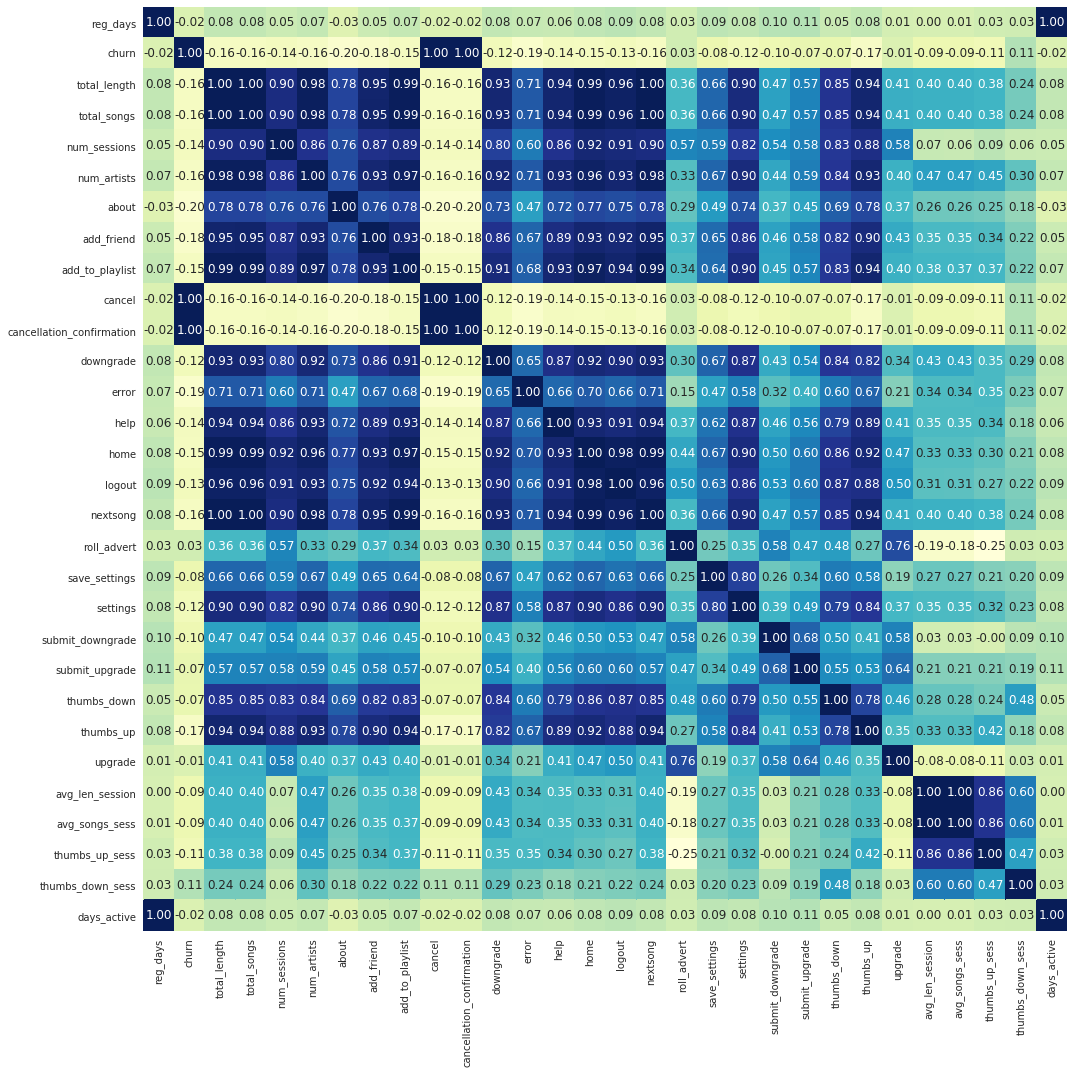

In [29]:
# Heatmap of correlation of the numeric columns

corr = np.corrcoef(pd_df[num_cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(20,17)})
hm = sns.heatmap(corr, cbar=False, annot=True, square=True, 
                 fmt='.2f', yticklabels=num_cols, xticklabels=num_cols, cmap="YlGnBu")

In [30]:
#Highly correlated fields > 0.95
# total_length, total_songs, num_artists, add_to_playlist, add_friend, home, logout, nextsong
# churn, cancel_confirmation, cancel
# avg_song_session, avg_len_sess

cols_to_drop = ['total_length', 'num_artists', 'add_to_playlist', 'add_friend', 'home', 'logout',
                       'nextsong', 'cancellation_confirmation', 'cancel', 'avg_songs_sess']
user_df = user_df.drop(*cols_to_drop)

In [31]:
# drop highly correlated fields

pd_df = pd_df.drop(columns=cols_to_drop)

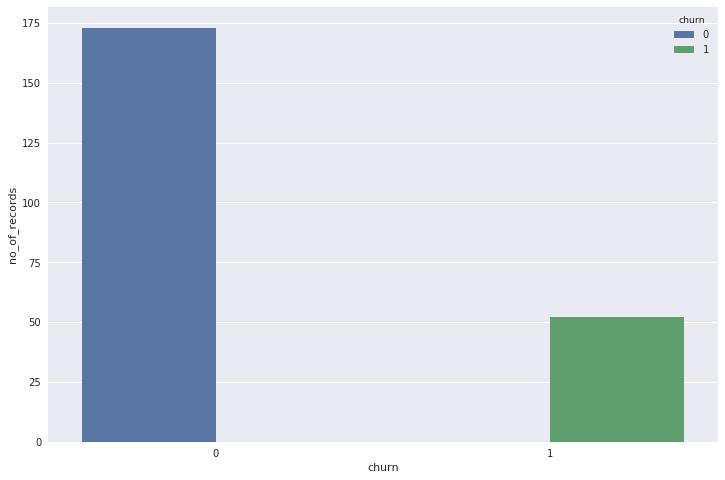

In [32]:
# Bar plot of churn values

grouped = pd_df.groupby(['churn'])['churn'].count().rename('no_of_records').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x="churn", y="no_of_records", hue="churn", data=grouped)
plt.show()

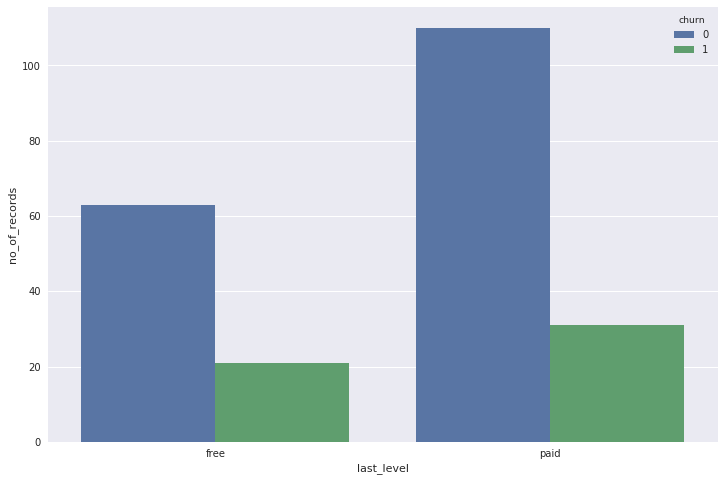

In [33]:
# churn by last_level

grouped = pd_df.groupby(['last_level', 'churn'])['churn'].count().rename('no_of_records').reset_index()
plt.figure(figsize=(12,8))
sns.barplot(x="last_level", y="no_of_records", hue="churn", data=grouped)
plt.show()

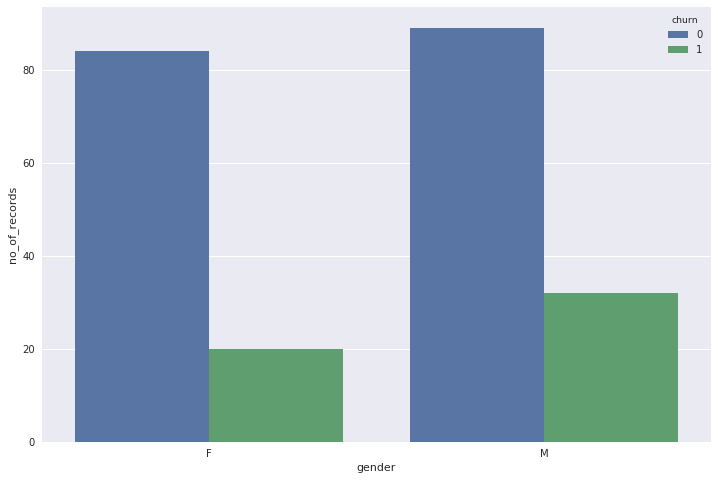

In [34]:
# churn by gender

grouped = pd_df.groupby(['gender', 'churn'])['churn'].count().rename('no_of_records').reset_index()
plt.figure(figsize=(12,8))
sns.barplot(x="gender", y="no_of_records", hue="churn", data=grouped)
plt.show()

In [35]:
cols_to_plot = pd_df.select_dtypes(['int32','int64','float32','float64']).columns.tolist()

cols_to_plot2 = cols_to_plot[9:].append(cols_to_plot[0])

cols_to_plot2 = cols_to_plot[9:]

cols_to_plot2.append('churn')

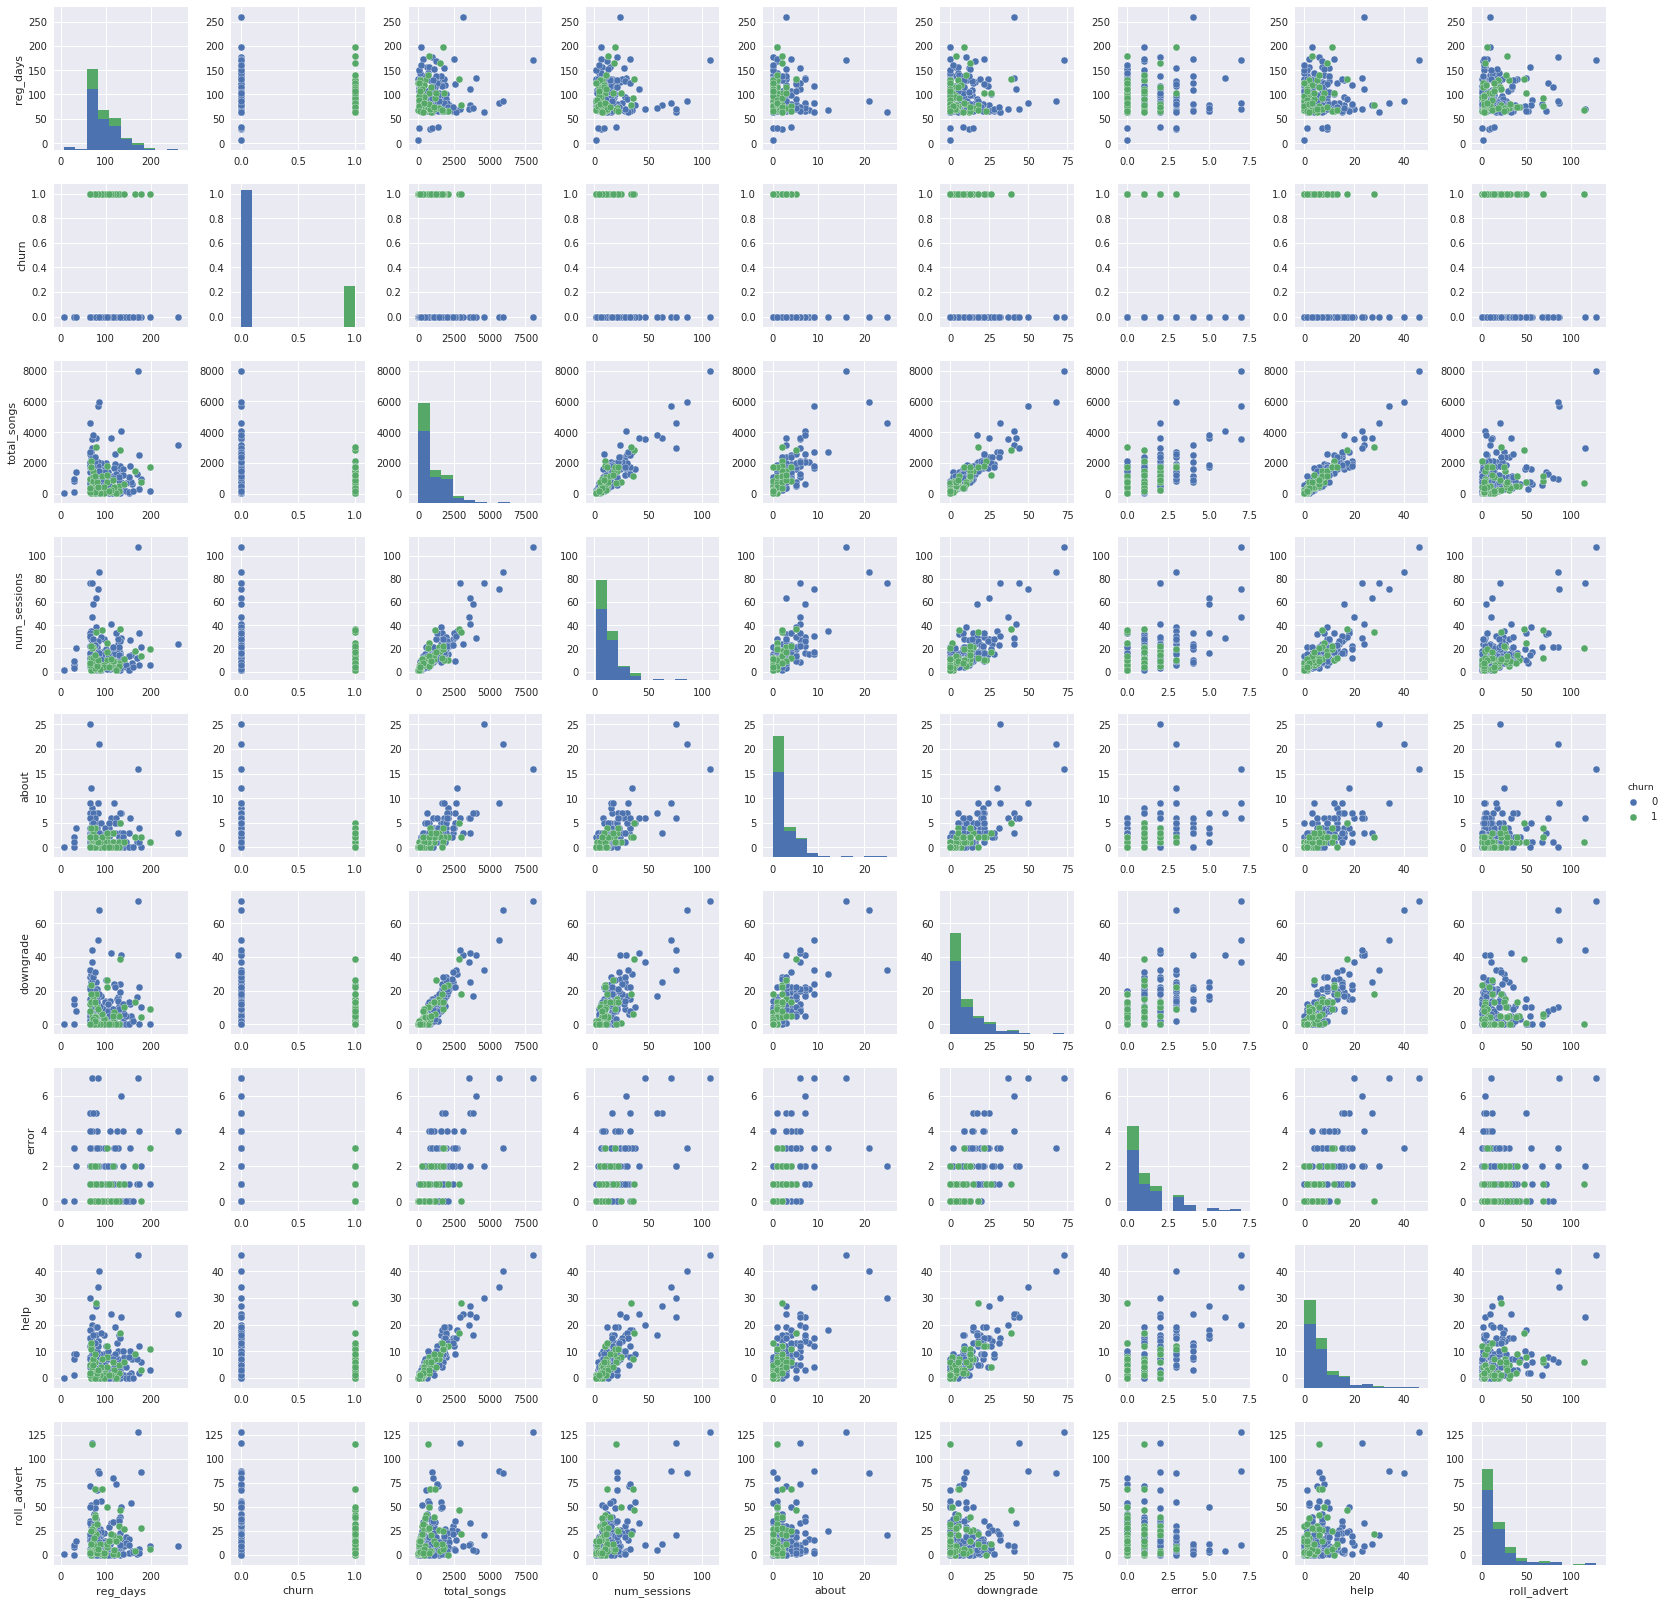

In [36]:
# Pairplots of numeric features

sns.pairplot(pd_df[cols_to_plot[:9]], hue="churn", diag_kind="hist")
plt.show()

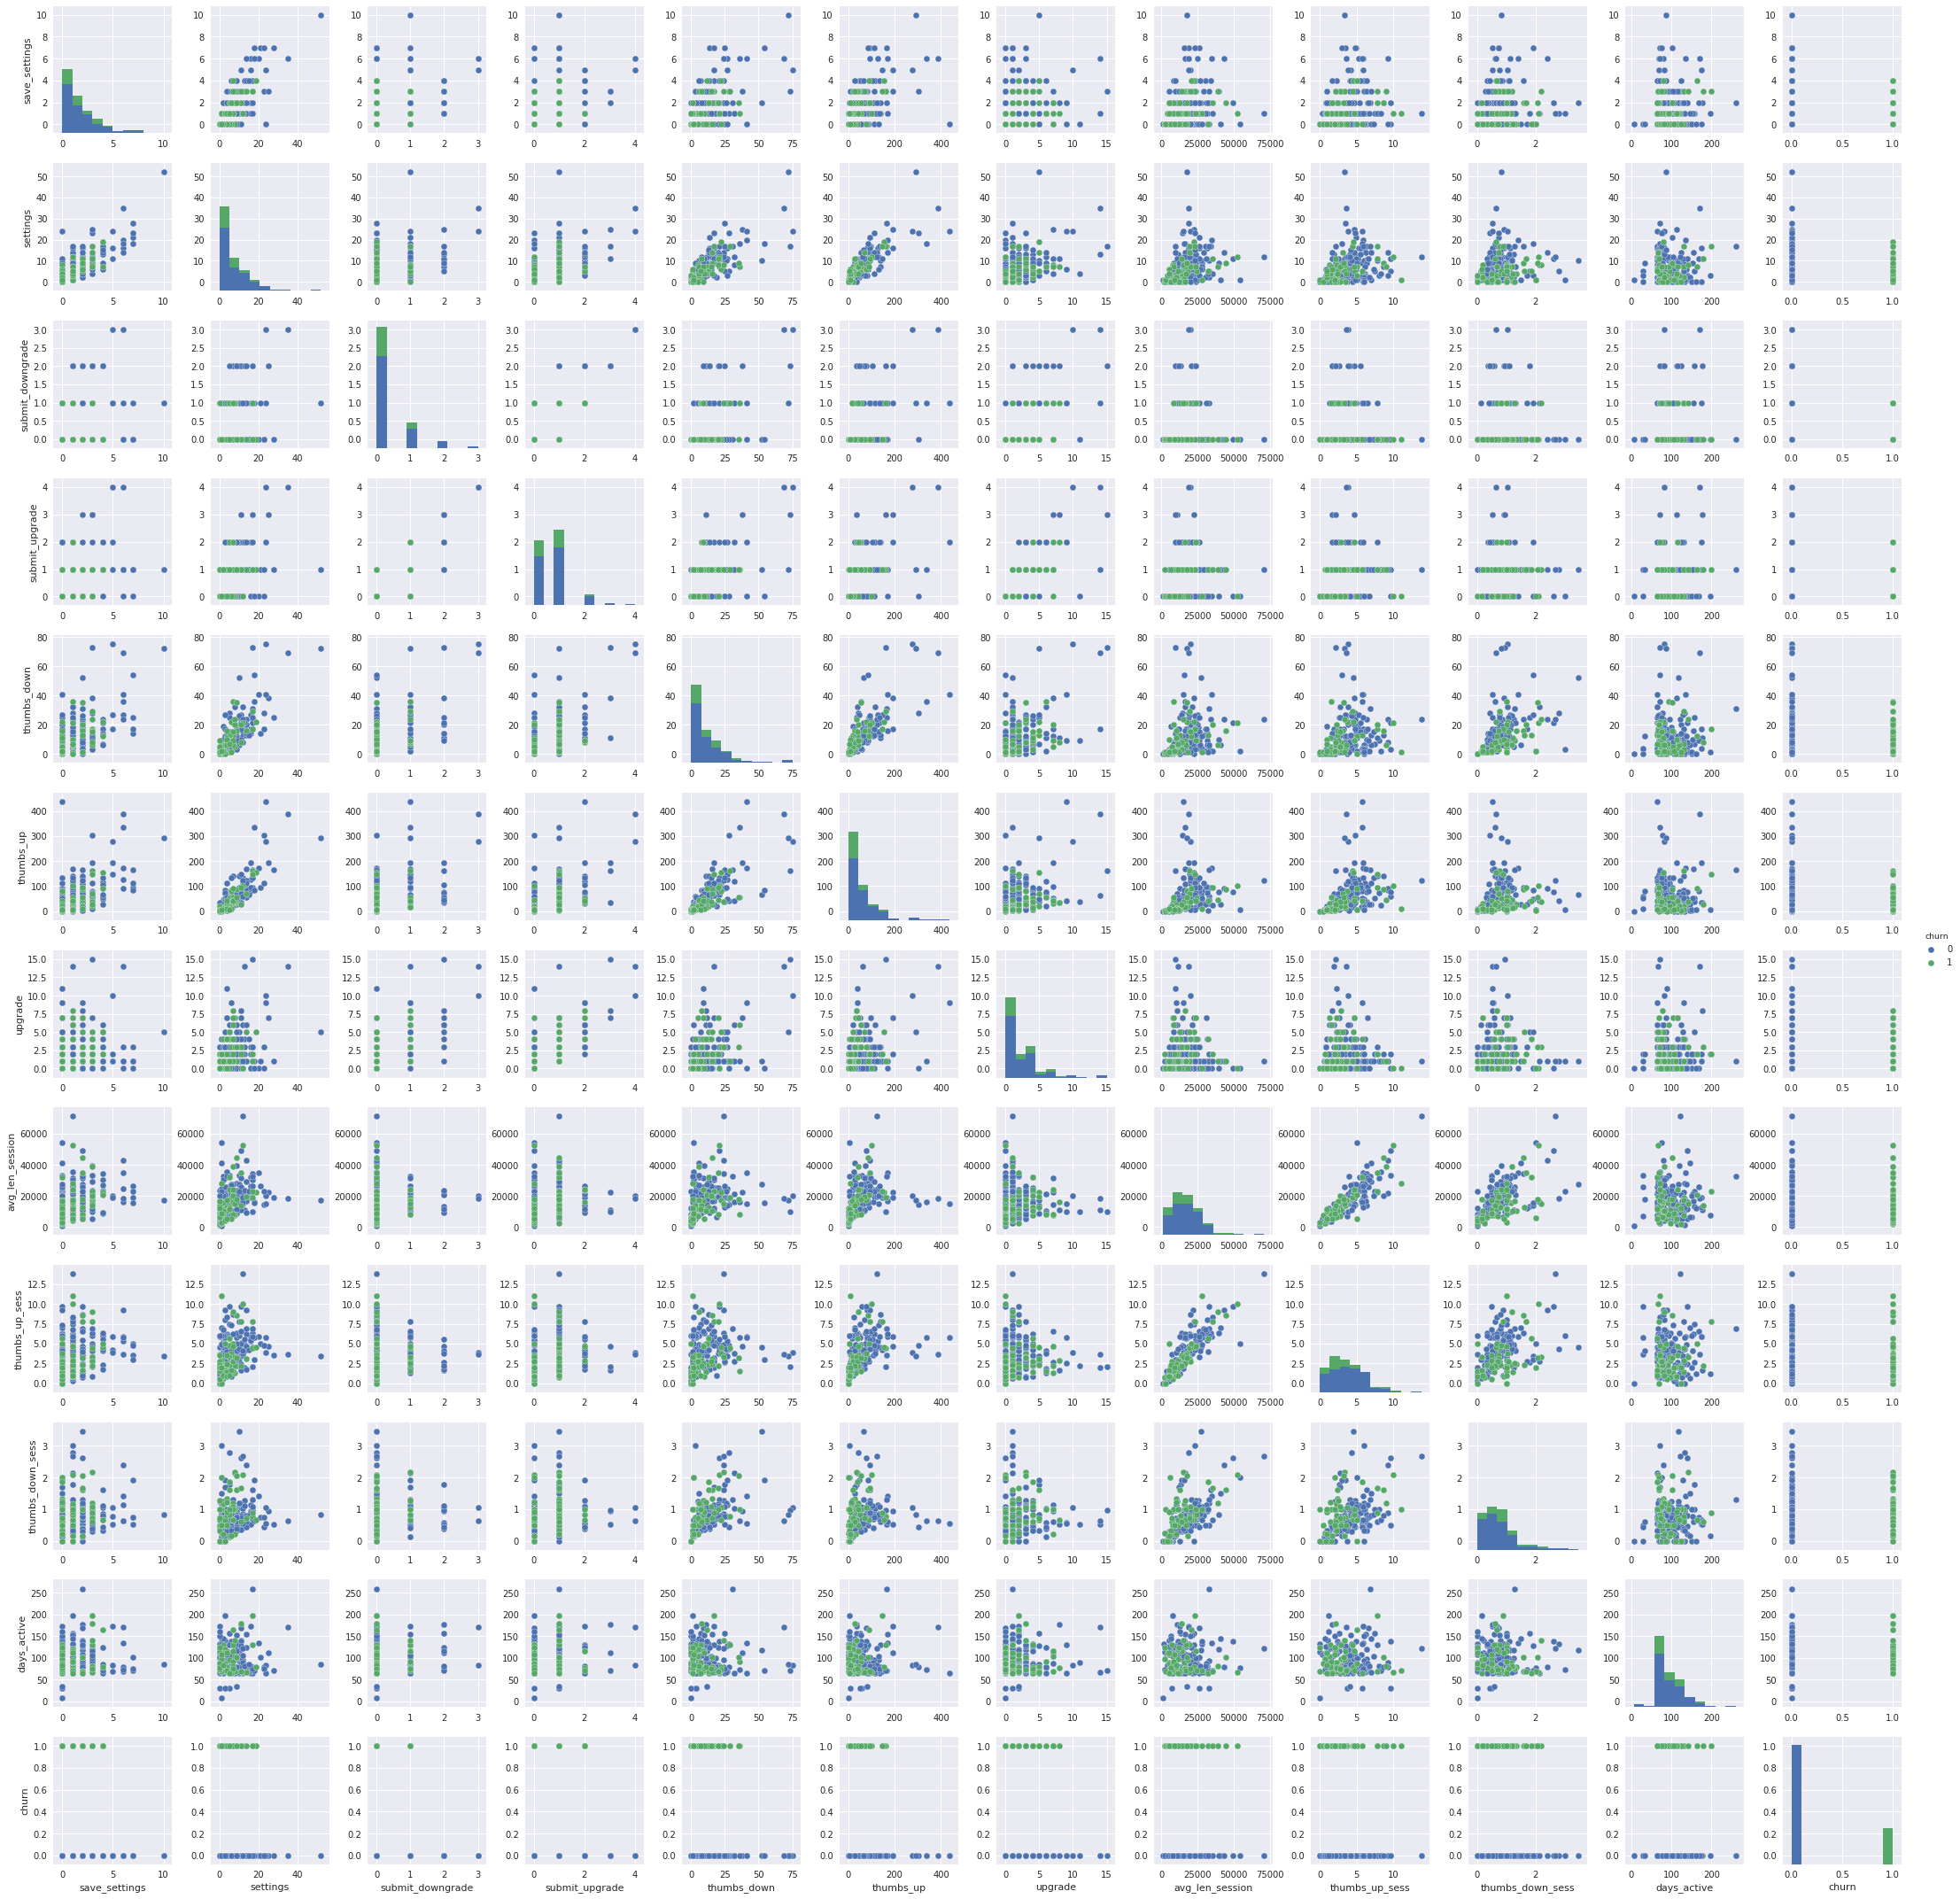

In [37]:
sns.pairplot(pd_df[cols_to_plot2], hue="churn", diag_kind="hist")
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [38]:
### Drop user ID and date fields and rename churn to label

user_df = user_df.drop('userId', 'reg_date', 'first_date', 'last_date')

user_df = user_df.withColumnRenamed('churn', 'label')

In [39]:
user_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- reg_days: integer (nullable = true)
 |-- last_level: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- total_songs: long (nullable = false)
 |-- num_sessions: long (nullable = false)
 |-- about: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- error: long (nullable = true)
 |-- help: long (nullable = true)
 |-- roll_advert: long (nullable = true)
 |-- save_settings: long (nullable = true)
 |-- settings: long (nullable = true)
 |-- submit_downgrade: long (nullable = true)
 |-- submit_upgrade: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- avg_len_session: double (nullable = true)
 |-- thumbs_up_sess: double (nullable = true)
 |-- thumbs_down_sess: double (nullable = true)
 |-- days_active: integer (nullable = true)



In [40]:
# create a list of numeric column names

numeric_fields = [f.name for f in user_df.schema.fields if (isinstance(f.dataType, DoubleType)\
      or isinstance(f.dataType, IntegerType)\
      or isinstance(f.dataType, LongType))]

In [41]:
numeric_fields.remove('label')

In [42]:
# create a list of categorical column names

categorical_fields = [f.name for f in user_df.schema.fields if isinstance(f.dataType, StringType)]

In [43]:
# Index and OneHotEncode the categorical features

stages = []

for col in categorical_fields:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol()], outputCols=[col+'_enc'])
    stages.extend([indexer, encoder])

In [44]:
# Standardize numerical features

for col in numeric_fields:
    assembler = VectorAssembler(inputCols=[col], outputCol=col+'_vec')
    scaler = StandardScaler(inputCol=col+'_vec', outputCol=col+'_scl')
    stages.extend([assembler, scaler])
    


In [45]:
# Assemble all the inputs into a features column

input_cols = [col+'_enc' for col in categorical_fields] + [col+'_scl' for col in numeric_fields]
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
stages.append(assembler)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [46]:
# split data into train and test

train, test = user_df.randomSplit([0.7,0.3], seed=12)


In [47]:
# Function to model the data

def model_data(model, stages):
    '''
    Create pipeline, fit the pipeline on training data and predict on test data.
    
    '''
    pipeline = Pipeline(stages=stages+[model])
    fitted = pipeline.fit(train)
    pred = fitted.transform(test)
    return pred

In [48]:
# Function to evaluate the model

def evaluate_model(predictions):
    '''
    Evaluates model performance. Calculates accuracy, F1 score, precision and recoall.
    Prints out the metrics including the confusion matrix.
    '''
    tp = predictions.where((predictions.prediction==predictions.label) & (predictions.prediction==1)).count()
    tn = predictions.where((predictions.prediction==predictions.label) & (predictions.prediction==0)).count()
    fp = predictions.where((predictions.prediction!=predictions.label) & (predictions.prediction==1)).count()
    fn = predictions.where((predictions.prediction!=predictions.label) & (predictions.prediction==0)).count()
    
    evaluator = MulticlassClassificationEvaluator()
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName : 'accuracy'})
    f_score = evaluator.evaluate(predictions, {evaluator.metricName : 'f1'})
    
    print('Counfusion matrix')
    print('TP {0} | FP {1}'.format(tp, fp))
    print('FN {0} | TN {1}'.format(fn, tn))
    print('Accuracy: %0.3f' % accuracy)
    print('F1 score: %0.3f' % f_score)
    

In [49]:
# Define the models

models = {'Logistic Regression': LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0),
         'Decision Tree Classifier': DecisionTreeClassifier(),
         'Random Forest Classifier': RandomForestClassifier()}


In [50]:
# Loop to model the data and evaluate the results of each model

for name, model in models.items():
    pred = model_data(model, stages)
    print('-------------------------')
    print(name)
    print('-------------------------')
    evaluate_model(pred)
    print('')
    

-------------------------
Logistic Regression
-------------------------
Counfusion matrix
TP 1 | FP 1
FN 18 | TN 55
Accuracy: 0.747
F1 score: 0.661

-------------------------
Decision Tree Classifier
-------------------------
Counfusion matrix
TP 6 | FP 10
FN 13 | TN 46
Accuracy: 0.693
F1 score: 0.684

-------------------------
Random Forest Classifier
-------------------------
Counfusion matrix
TP 1 | FP 2
FN 18 | TN 54
Accuracy: 0.733
F1 score: 0.653



In [51]:
# Perform cross validation for Logistic Regression Model

lr =  LogisticRegression(elasticNetParam=0)

pipeline = Pipeline(stages=stages+[lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, 0.01, 0.001]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [52]:
# Fit and transform the model to get predictions for the test data

fitted_cv = crossval.fit(train)

results = fitted_cv.transform(test)

In [53]:
# Evaluate the results

evaluate_model(results)

Counfusion matrix
TP 2 | FP 0
FN 17 | TN 56
Accuracy: 0.773
F1 score: 0.697


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.